# Simulation script for RF manipulation

## Introduction

<img src="./input_files/LHC25%2348b_BCMS_PS_TFB_2018/RF.png" alt="rf program" width="600"/>

This is the complete acceleration cycle in the PS for beams sent to the LHC for collisions. The RF program is shown in colors. We will focus first on the last RF manipulation consisting in splitting bunches in two, twice. We go from the rf harmonic $h=21$ (C10) to $h=42$, (C20) then $h=84$ (C40). This corresponds to the time in the cycle between $2.710$ s and $2.843$ s.

<img src="./input_files/LHC25%2348b_BCMS_PS_TFB_2018/foursplitb6_datamatrix.png" alt="foursplit" width="600"/>

This is the evolution of the bunch profile in the longitudinal direction (x-axis, expressed in time), during the manipulation (y-axis, expressed in number of machine turns). Each line in the plot corresponds to a measured profile in the Wall Current Monitor. Both splittings can be seen, an error in phase between the rf systems at each step will result in a non-uniform distribution of the particles in the end. note that we have $12$ to $18$ bunches at the start (in $h=21$), yielding $48$ to $72$ bunches after the manipulation. Only one bunch is shown here, all should be identical if the prior manipulations are done correctly...

<img src="./input_files/LHC25%2348b_BCMS_PS_TFB_2018/foursplitb6_firstprofile.png" alt="foursplit" width="600"/>

This is the very first profile measured, before the splittings. The bunch is close to a parabola with the relationship

$
\lambda = \lambda_0\left[1-4\left(\frac{\tau}{\tau_l}\right)\right]^{\mu+1/2}
$

## Imports

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
import time
import datetime

In [2]:
# BLonD imports
from blond.input_parameters.ring import Ring, RingOptions
from blond.input_parameters.rf_parameters import RFStation
from blond.beam.beam import Proton, Beam
from blond.beam.profile import Profile, CutOptions
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
# from blond.impedances.impedance_sources import Resonators, InputTable
# from blond.impedances.impedance import InducedVoltageFreq, InductiveImpedance, TotalInducedVoltage
from blond.beam.distributions_multibunch import match_beam_from_distribution

## Simulation inputs

In [3]:
# Simulation parameters
plot_turn = 5000
time_sim_start = 1827e-3
time_sim_end = 1890e-3

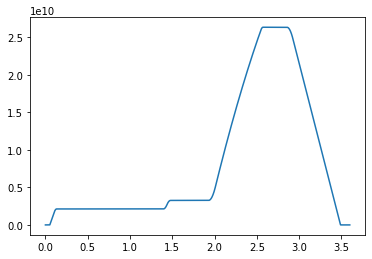

In [4]:
# General parameters
circumference = 2.*np.pi*100.                    # Machine circumference [m]
gamma_transition = 6.1                           # Transition gamma
momentum_compaction = 1./gamma_transition**2  # Momentum compaction array
particle_type = Proton()
ramp_interpolation = 'linear'
loaded_momentum = np.load('./input_files/LHC25#48b_BCMS_PS_TFB_2018/ramp.npz')
time_momentum = loaded_momentum['time']*1e-3        # Time [s] 
momentum = loaded_momentum['momentum']*1e9          # Momentum [eV/c]

plt.figure()
plt.plot(time_momentum, momentum)

In [5]:
# RF parameters 

v14_factor = 1.

n_rf_systems = 3                                         # Number of rf systems 
harmonic_numbers = [7, 14, 21]                          # Harmonic numbers
loaded_h7 = np.load('./input_files/LHC25#48b_BCMS_PS_TFB_2018/C10_h-7.npz')
time_h7 = loaded_h7['time']*1e-3                          # Time [s]
voltage_h7 = loaded_h7['amplitude']*1e3                   # Voltage [V]
loaded_h14 = np.load('./input_files/LHC25#48b_BCMS_PS_TFB_2018/C10_h-14.npz')
time_h14 = loaded_h14['time']*1e-3                          # Time [s]
voltage_h14 = loaded_h14['amplitude']*1e3  * v14_factor                 # Voltage [V]
loaded_h21 = np.load('./input_files/LHC25#48b_BCMS_PS_TFB_2018/C10_h-21.npz')
time_h21 = loaded_h21['time']*1e-3                          # Time [s]
voltage_h21 = loaded_h21['amplitude']*1e3                   # Voltage [V]

(0.0, 42902.01432000001)

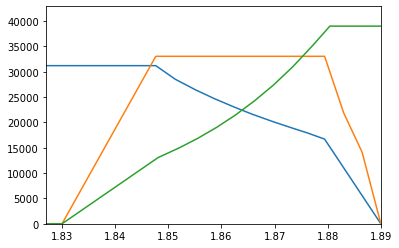

In [6]:
plt.figure()
plt.plot(time_h7, voltage_h7)
plt.plot(time_h14, voltage_h14)
plt.plot(time_h21, voltage_h21)
plt.xlim((time_sim_start,time_sim_end))
plt.ylim((0, 1.1*voltage_h21[time_h21<=time_sim_end][-1]))

In [7]:
# Phase offsets, the possible errors
dpc14 = 0
dpc21 = 0
phi_offsets =  [np.pi, np.pi+dpc14/180*np.pi, np.pi+dpc21/180*np.pi]     # For 2x2 splitting

In [8]:
# Beam parameters
n_bunches = 1

initial_bunch_length_full = 155e-9
initial_exponent = 1.

n_macroparticles_per_bunch = int(1e4)
intensity_per_bunch = 1.3e11

intensity = intensity_per_bunch*n_bunches*3*4
n_macroparticles = int(n_macroparticles_per_bunch*n_bunches*4)

In [20]:
# Profile parameters
n_slices_per_bunch = 2**10
bunch_spacing_buckets = 1
n_slices = int(n_slices_per_bunch*(bunch_spacing_buckets*(harmonic_numbers[0]-1)+1))
cut_left = 0.
cut_right = 2*np.pi*(bunch_spacing_buckets*(harmonic_numbers[0]-1)+1)

## Building BLonD objects

In [21]:
### Ring object

momentum = momentum[(time_momentum>=time_sim_start-2e-3)*(time_momentum<=time_sim_end+2e-3)]
time_momentum = time_momentum[(time_momentum>=time_sim_start-2e-3)*(time_momentum<=time_sim_end+2e-3)]


ring_options = RingOptions(interpolation=ramp_interpolation,
                              t_start=time_sim_start,
                              t_end=time_sim_end)
ring = Ring(circumference, momentum_compaction,
               (time_momentum, momentum), particle_type,
               RingOptions=ring_options)

C:\Users\Joel Wulff\.conda\envs\cern\lib\site-packages\blond-2.0.11-py3.9.egg\blond\input_parameters\ring.py:232: UserWarning: WARNING in Ring: The number of turns for the simulation was changed by passing a momentum program.
  warnings.warn("WARNING in Ring: The number of turns for the " +


28890
0.9611449523237751
3.6226087324732186
3398992660.006074
0.02687449610319807
3398992660.006074


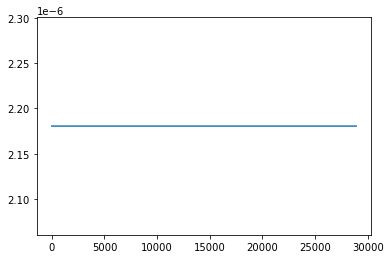

In [22]:
print(ring.n_turns)
print(ring.beta[0,0])
print(ring.gamma[0,0])
print(ring.energy[0,0])
print(ring.alpha_0[0,0])
print(ring.energy[0,0])
plt.figure()
plt.plot(ring.t_rev[:])

In [23]:
### RFStation object

voltage_h7 = voltage_h7[(time_h7>=time_sim_start)*(time_h7<=time_sim_end)]
time_h7 = time_h7[(time_h7>=time_sim_start)*(time_h7<=time_sim_end)]

voltage_h14 = voltage_h14[(time_h14>=time_sim_start)*(time_h14<=time_sim_end)]
time_h14 = time_h14[(time_h14>=time_sim_start)*(time_h14<=time_sim_end)]

voltage_h21 = voltage_h21[(time_h21>=time_sim_start)*(time_h21<=time_sim_end)]
time_h21 = time_h21[(time_h21>=time_sim_start)*(time_h21<=time_sim_end)]

rf_station = RFStation(ring, harmonic_numbers,
                       ((time_h7, voltage_h7),
                        (time_h14, voltage_h14),
                        (time_h21, voltage_h21)),
                       phi_offsets,
                       n_rf=n_rf_systems)

C:\Users\Joel Wulff\.conda\envs\cern\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<__array_function__ internals>:5: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


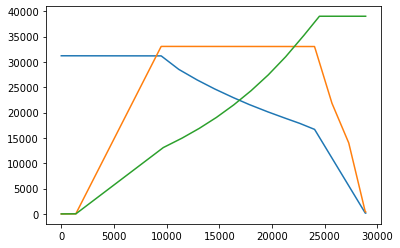

In [24]:
plt.figure()
plt.plot(rf_station.voltage[0,:])
plt.plot(rf_station.voltage[1,:])
plt.plot(rf_station.voltage[2,:])

In [25]:
### Beam
beam = Beam(ring, n_macroparticles, intensity)


### Profile
cut_options = CutOptions(cut_left, cut_right, n_slices=n_slices,
                         cuts_unit='rad', RFSectionParameters=rf_station)
profile = Profile(beam, CutOptions=cut_options)

C:\Users\Joel Wulff\.conda\envs\cern\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
### Tracker

longitudinal_tracker = RingAndRFTracker(rf_station, beam)

full_tracker = FullRingAndRF([longitudinal_tracker])


### Beam generation
distribution_options = {'type': 'binomial', 'exponent': initial_exponent,
                        'bunch_length': initial_bunch_length_full,
                        'bunch_length_fit': 'full', 
                        'density_variable': 'Hamiltonian'}

match_beam_from_distribution(beam, full_tracker, ring,
                             distribution_options, n_bunches,
                             bunch_spacing_buckets,
                             n_points_potential=int(1e3))

1 stationary bunches without intensity generated


C:\Users\Joel Wulff\.conda\envs\cern\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


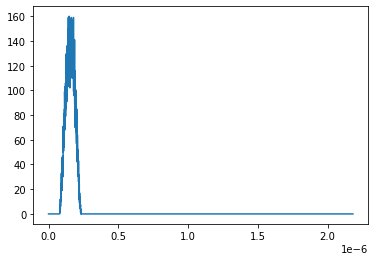

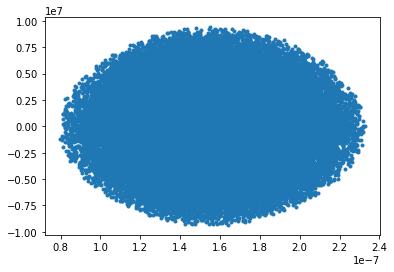

In [27]:
profile.track()
plt.figure()
plt.plot(profile.bin_centers, profile.n_macroparticles)

plt.figure()
plt.plot(beam.dt, beam.dE, '.')

## Tracking

In [28]:
# Move the bunches in the center of the turn
#beam.dt += rf_station.t_rf[0,0]

datamatrix = np.zeros((int(ring.n_turns/100)+1, len(profile.n_macroparticles)))

for turn in range(ring.n_turns):

    if(turn%plot_turn==0):
        t0 = time.perf_counter()
        
    if (turn%100==0):
        datamatrix[int(turn/100), :] = profile.n_macroparticles

    # Track
    full_tracker.track()
    profile.track()
    

    if(turn%plot_turn==0):
        t1 = time.perf_counter()
        print('Turn %d over %d, ETC: %s' %(
            turn, ring.n_turns, datetime.timedelta(seconds=(t1-t0)*(ring.n_turns-turn))))

C:\Users\Joel Wulff\.conda\envs\cern\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Turn 0 over 28890, ETC: 0:00:27.500391
Turn 5000 over 28890, ETC: 0:00:12.936435
Turn 10000 over 28890, ETC: 0:00:10.315829
Turn 15000 over 28890, ETC: 0:00:07.772844
Turn 20000 over 28890, ETC: 0:00:04.850384
Turn 25000 over 28890, ETC: 0:00:02.104490


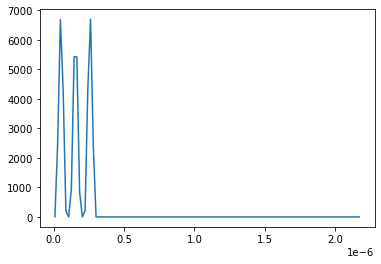

In [18]:
plt.figure()
plt.plot(profile.bin_centers, profile.n_macroparticles)
# plt.xlim((rf_station.t_rf[0,0], rf_station.t_rf[0,0]+rf_station.t_rf[0,0]))

C:\Users\Joel Wulff\.conda\envs\cern\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


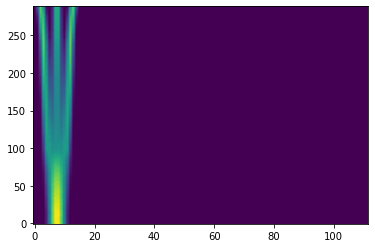

In [19]:
plt.figure()
plt.imshow(datamatrix, aspect='auto', origin='lower')
plt.xlim((0, 20))